In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

** NOTE: ** We have commented some outputs so that the notebook isn't much longer than it already is.

# Familiarizing with the tools and data

Let's first analyze the HTML content of the IS-Academia directory. We will this by using the `requests` library to `GET` the HTML content given a URL. We obtained the following URL using Postman (https://www.getpostman.com/) and Postman Interceptor.

In [2]:
r = requests.get("http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247")

Now we will use `BeautifulSoup` to parse through the data and visualize it nicely with the `pretiffy()` method.

In [3]:
soup = BeautifulSoup(r.content, 'html.parser')
#print(soup.prettify())

With `BeautifulSoup`, we can conveniently dig deeper into the HTML content as described in this tutorial: https://www.crummy.com/software/BeautifulSoup/bs4/doc/. We will isolate the filters used to distinguish students by Major (Unité académique), Academic Year (Période académique), Student Status (Période pédagogique), and Semester Type (Type de semestre). We have identified from the output above that the filters are in the `body`, between `<table>` tags with `id="filtre"`. Finally, we can use `find_all('tr')` to get each filter as an entry in a list.

In [4]:
filters = soup.body.find(id="filtre").find_all('tr')
#print(filters)

Admittedly, not the nicest output. And besides the fact that there are square brackets, it's hard to even say that it's a list! Let's try to output this more cleanly. From the `prettify()` output, we saw that each filter, e.g. `Architecture` for Unité académique or `2010-2011` for Période académique has an `option` tag surrounding it. Let's use `find_all(option)` with each item in the above list to "cleanly" output the filter options.

In [5]:
for field in filters:
    print(field.find_all('option'))

[<option value="null"></option>, <option value="942293">Architecture</option>, <option value="246696">Chimie et génie chimique</option>, <option value="943282">Cours de mathématiques spéciales</option>, <option value="637841336">EME (EPFL Middle East)</option>, <option value="942623">Génie civil</option>, <option value="944263">Génie mécanique</option>, <option value="943936">Génie électrique et électronique </option>, <option value="2054839157">Humanités digitales</option>, <option value="249847">Informatique</option>, <option value="120623110">Ingénierie financière</option>, <option value="946882">Management de la technologie</option>, <option value="944590">Mathématiques</option>, <option value="945244">Microtechnique</option>, <option value="945571">Physique</option>, <option value="944917">Science et génie des matériaux</option>, <option value="942953">Sciences et ingénierie de l'environnement</option>, <option value="945901">Sciences et technologies du vivant</option>, <option va

That's a bit better. We can see a `value` associated with each field option, e.g. `249847` for `Informatique`. Let's actually use some of these filters on the website itself and intercept the requests using Postman + Postman Interceptor. Postman helps us track which URLs are requested and to analyze the corresponding HTML. Let's check out the URL and HTML content (with `BeautifulSoup`) when we select the following field options: `Informatique`, `2009-2010`, `Bachelor semestre 1`, and `Semestre d'automne`.

http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247&ww_c_langue=&ww_i_reportModelXsl=133685270&zz_x_UNITE_ACAD=Informatique&ww_x_UNITE_ACAD=249847&zz_x_PERIODE_ACAD=2009-2010&ww_x_PERIODE_ACAD=978195&zz_x_PERIODE_PEDAGO=Bachelor+semestre+1&ww_x_PERIODE_PEDAGO=249108&zz_x_HIVERETE=Semestre+d%27automne&ww_x_HIVERETE=2936286&dummy=ok

In the URL we can see the options we selected! Moreover, they have been used as parameters for the URL along with their corresponding `value` attribute. The parameter names (that `Informatique`, `2009-2010`, `Bachelor semestre 1`, and `Semestre d'automne` are being set to) could be identified by navigating through our `filters` list (by going into the `td` tag and then selecting the `name` attribute of the `input` tag).

In [6]:
for field in filters:
    print(field.td.input["name"])

zz_x_UNITE_ACAD
zz_x_PERIODE_ACAD
zz_x_PERIODE_PEDAGO
zz_x_HIVERETE


`zz_*` seems to be for the string parameter name and `xx_*` for the corresponding `value` attribute. However, it is also possible to get the same HTML content without the `zz_*` parameters by adding the `ww_b_list` parameter (we found this out using Postmaster):

http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247&ww_i_reportModelXsl=133685270&ww_x_HIVERETE=2936286&ww_x_PERIODE_ACAD=978195&ww_x_UNITE_ACAD=249847&ww_x_PERIODE_PEDAGO=249108

When checking out the HTML content, we see a new table at the bottom (corresponding to the options we see on the IS-Academia portal) with attribute `border="0"`. Let's check it out with `BeautifulSoup`.

In [7]:
r = requests.get("http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247&ww_c_langue=&ww_i_reportModelXsl=133685270&zz_x_UNITE_ACAD=Informatique&ww_x_UNITE_ACAD=249847&zz_x_PERIODE_ACAD=2009-2010&ww_x_PERIODE_ACAD=978195&zz_x_PERIODE_PEDAGO=Bachelor+semestre+1&ww_x_PERIODE_PEDAGO=249108&zz_x_HIVERETE=Semestre+d%27automne&ww_x_HIVERETE=2936286&dummy=ok")
soup = BeautifulSoup(r.content, 'html.parser')
#print(soup.prettify())

We now see this new parameter `ww_x_GPS`. Let's follow the link for `Informatique, 2009-2010, Bachelor semestre 1` and analyze as before. The webpage now shows the corresponding list of students! With Postman, we see a `GET` request with the following URL:

http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=213617925&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_b_list=1&ww_x_UNITE_ACAD=249847&ww_x_PERIODE_ACAD=978195&ww_x_PERIODE_PEDAGO=249108&ww_x_HIVERETE=2936286

This is very similar to previous URL with one key difference: the new parameter `ww_x_GPS` with its corresponding value has been added to the URL.

We have now "cracked" the manner in which to extract the desired HTML content from IS-Academia! The general procedure is as follows:

1. Identity the `value` attributes according to desired filters.
2. Using `requests`, build the URL for filter search results with the `value` attributes as parameters of the following base URL: http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247&ww_c_langue=&ww_i_reportModelXsl=133685270
3. Use `BeautifulSoup` to extract the `ww_x_GPS` parameter value from the HTML content.
4. With `requests`, build the URL with the newly acquired `ww_x_GPS` value and the `value` attributes as parameters of the following base URL: http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_b_list=1
5. We then have a table of students in HTML format. We can use then use `Beautiful Soup` in order to conveniently access the data.

Below we will go through the above steps for picking out the students we need for our analysis in the exercises.

#### 1. Identify `value` attributes according to desired filters

In order to perform the first step conveniently, we will create a few dictionaries so we can "translate" the desired filter options into their corresponding `value` attributes. These dictionaries will be used in the following exercises. The following is our base url for the main page.

In [8]:
# same URL as before, identified with postmam
r = requests.get("http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247")
# scrape content using BeautifulSoup
soup = BeautifulSoup(r.content, 'html.parser')
# obtain list of filters as previously described
filters = soup.body.find(id="filtre").find_all('tr')

Now we define a new function `create_series()` in order to scrape the string and corresponding `value` attribute from a list of `option`s. The function will finally place them in a dictionary with the string as the key and the `value` attribute as the (you, got it) value. We then construct a pandas `Series` from the dictionary and return it.

In [9]:
# function to create Series for each filter
def create_series(field_list):
    field_dict = {}
    for i in range(1, len(field_list)):
        field_dict[field_list[i].string] = field_list[i]["value"]
    return pd.Series(data=field_dict)

# Unité académique, Période académique, Période pédagogique, Type de semestre
major,acad_yr,status,semester = [create_series(filters[x].find_all('option')) for x in range(0,4)]

Let's `pickle` these `Series` so we don't have to have to rely on `requests`.

In [10]:
pickle_names = ["major_pickle", "acad_yr_pickle", "status_pickle", "sem_pickle"]
dicts = [major,acad_yr,status,semester]
res = [dic.to_pickle(pname) for dic, pname in zip(dicts,pickle_names)]

Now we can convieniently obtain the necessary parameters to build the URLs for filtering students based on Major (Unité académique), Academic Year (Période académique), Student Status (Période pédagogique), and Semester Type (Type de semestre)! Below are some examples.

In [11]:
print(major["Informatique"])
print(acad_yr["2012-2013"])
print(status["Master semestre 3"])
print(semester["Semestre de printemps"])

249847
123456101
2230128
2936295


#### 2. Using `requests`, build the URL for the filter search results with the `value` attributes as parameters

Now let's build the required URL so we can obtain the `ww_x_GPS` parameter value to then gather the students that meet our search criteria. The following is our base URL for the filter search results:

In [12]:
FILTER_BASE_URL = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247&ww_c_langue=&ww_i_reportModelXsl=133685270'

Now using `requests`, we can build the URL with the necessary parameters as we saw above. We have the following parameters:

In [13]:
# parameter keys
PARAM_MAJ = 'ww_x_UNITE_ACAD'
PARAM_YR = 'ww_x_PERIODE_ACAD'
PARAM_STATUS = 'ww_x_PERIODE_PEDAGO'
PARAM_SEM = 'ww_x_HIVERETE'

Now let's pass parameters to the URL as described here (http://docs.python-requests.org/en/master/user/quickstart/#passing-parameters-in-urls) and make a `GET` request. Let's say we want students in `Informatique`, `2009-2010`, `Bachelor semestre 1`, and `Semestre d'automne` as before.

In [14]:
# create URL for filtered result
payload_filter = {PARAM_MAJ: major['Informatique'], 
                  PARAM_YR: acad_yr['2009-2010'], 
                  PARAM_STATUS: status['Bachelor semestre 1'], 
                  PARAM_SEM: semester["Semestre d'automne"]}
r = requests.get(FILTER_BASE_URL, params=payload_filter)
print(r.url)

http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247&ww_c_langue=&ww_i_reportModelXsl=133685270&ww_x_PERIODE_ACAD=978195&ww_x_UNITE_ACAD=249847&ww_x_HIVERETE=2936286&ww_x_PERIODE_PEDAGO=249108


#### 3. Use `BeautifulSoup` to extract the `ww_x_GPS` parameter value from the HTML content. 

Let's see how we can use `BeautifulSoup` to navigate through the HTML content and extract the `ww_x_GPS` parameter value. `prettify()` can help us with this.

In [15]:
soup = BeautifulSoup(r.content, 'html.parser')
#print(soup.prettify())

We need to pick out the `a` tags that have a `class` attribute equal to `ww_x_GPS`. This can be done with the `find_all()` method.

In [16]:
soup.find_all('a', class_='ww_x_GPS')

[<a class="ww_x_GPS" href="javascript:void(0)" onclick="loadReport('ww_x_GPS=-1');return false;">Tous</a>,
 <a class="ww_x_GPS" href="javascript:void(0)" onclick="loadReport('ww_x_GPS=213617925');return false;">Informatique, 2009-2010, Bachelor semestre 1</a>]

Now we have a list of HTML entries that contain `ww_x_GPS` values. The value itself is in the `onclick` attribute. We can extract the `ww_x_GPS` value by parsing the information contained in this attribute. We will assume that we only get two entries in the above list are our filter entries as our search criteria will ensure this. The two categories (which can be seen on the IS-Academia site) are "Tous" and the category of students we are interested in. "Tous" has a `ww_x_GPS` value of `-1` so we make sure to return the other value. "Tous" will list all the students and will probably give the same result but we will use the other `ww_x_GPS` value.

In [17]:
# assuming we only get two results with one of them being "Tous"
def extract_gps(content):
    soup = BeautifulSoup(content, 'html.parser')
    elements = soup.find_all('a', class_='ww_x_GPS')
    for element in elements:
        raw_info = element.attrs['onclick']
        gps = raw_info.split("'")[1].split('=')[1]
        if gps != "-1":
            return gps

gps = extract_gps(r.content)
print(gps)

213617925


#### 4. With `requests`, build the URL with the newly acquired `ww_x_GPS` value and the `value` attributes as parameters and obtain the HTML content.

Now we have a new base URL and an additional parameter for our payload.

In [18]:
PARAM_GPS = 'ww_x_GPS'
DATA_BASE_URL = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_b_list=1'

As in Step 2, we use `requests` to can build the URL with the necessary parameters.

In [19]:
# create URL for filtered result
payload_data = {PARAM_GPS: gps,
                PARAM_MAJ: major['Informatique'], 
                PARAM_YR: acad_yr['2009-2010'], 
                PARAM_STATUS: status['Bachelor semestre 1'], 
                PARAM_SEM: semester["Semestre d'automne"]}
r = requests.get(DATA_BASE_URL, params=payload_data)
print(r.url)

http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_b_list=1&ww_x_PERIODE_ACAD=978195&ww_x_UNITE_ACAD=249847&ww_x_GPS=213617925&ww_x_HIVERETE=2936286&ww_x_PERIODE_PEDAGO=249108


Following the above link takes us to the list of students meeting the following criteria: `Informatique`, `2009-2010`, `Bachelor semestre 1`, and `Semestre d'automne`. With `requests`, we can obtain the HTML content.

We have created the following function to combine Steps 1-4 given the Major, the Academic Year, the Student Status, and the Semester (Fall or Srping)

In [20]:
# combine steps 1-4 from procedure of extracting HTML content of desired students
def get_html_content(maj, yr, stat, sem):
    # obtain gps
    payload = {PARAM_MAJ: major[maj],
               PARAM_YR: acad_yr[yr], 
               PARAM_STATUS: status[stat],
               PARAM_SEM: semester[sem]}
    r_filt = requests.get(FILTER_BASE_URL, params=payload)
    gps = extract_gps(r_filt.content)
    # get list of students
    payload[PARAM_GPS] = gps
    r_list = requests.get(DATA_BASE_URL, params=payload)
    return r_list.content

#### 5. Use  `BeautifulSoup` to conveniently navigate through and access the data.

We can use the `html_content()` function to extract the HTML content according to a certain set of filters. And now we will use `BeautifulSoup` to extract the student info.

In [21]:
html_content = get_html_content("Informatique", "2009-2010", "Bachelor semestre 1", "Semestre d'automne")
soup_students = BeautifulSoup(html_content, 'html.parser')
# visualize
#print(soup_students.prettify())

From the `prettify()` output, we see that student info is contained within `<tr>` tags and that the first two entries between `<tr>` are for general information about the students. Therefore, to get all the students, we can use `find_all()` to get all the `<tr>` entries and drop the first two.

In [22]:
rows = soup_students.find_all('tr')
students = rows[2:]
# let's look at one of the student entries
students[0]

<tr><td style="white-space:nowrap">Monsieur</td><td style="white-space:nowrap">Abdallah Jad</td><td style="white-space:nowrap"></td><td style="white-space:nowrap"></td><td style="white-space:nowrap"></td><td style="white-space:nowrap"></td><td style="white-space:nowrap"></td><td style="white-space:nowrap">Présent</td><td style="white-space:nowrap"></td><td style="white-space:nowrap"></td><td>194197</td><td style="white-space:nowrap"></td></tr>

Each data point (e.g. gender, minor, sciper) about the student is surround by `<td>` tags. We can again use `find_all()` to access these elements and print these nicely. The second row of `rows` contains the label for each data point.

In [23]:
student = students[0].find_all('td')
labels = rows[1].find_all('th') # separated by <th> tags
for i in range(len(labels)):
    print(str(i) + ", " + labels[i].string + ": ", end="")
    print(student[i].string)

0, Civilité: Monsieur
1, Nom Prénom: Abdallah Jad
2, Orientation Bachelor: None
3, Orientation Master: None
4, Spécialisation: None
5, Filière opt.: None
6, Mineur: None
7, Statut: Présent
8, Type Echange: None
9, Ecole Echange: None
10, No Sciper: 194197


Now we can see the corresponding index for a particular data point of a student and pick out what we want for the following exercises!

# Exercise 1

_We will focus exclusively on the academic unit `Informatique`._

_Obtain all the data for the Bachelor students, starting from 2007. Keep only the students for which you have an entry for both `Bachelor semestre 1` and `Bachelor semestre 6`. Compute how many months it took each student to go from the first to the sixth semester. Partition the data between male and female students, and compute the average -- is the difference in average statistically significant?_

For this problem, we will create two `DataFrame`s: one for `Bachelor semestre 1` (B1) students and another for `Bachelor semestre 6` (B6) students. For the B1 `DataFrame`, we will start from 2007 and add students when they are first enrolled as `Informatique` and B1. If they repeat, their info will not be added again / updated. For B6, though, we will take the most recent entry. When storing the date of the semester, we will store it in `Year-Month` format; if the semester is Autumn we will use `09` as the month and if the semester is Spring we will use `03` as the month. The duration is calculated as: 12 x (`B6 Year` - `B1 Year`) + (`B6 Month` - `B1 Month`) + 6. We add 6 to account for the duration of the 6th semester.

**NOTE** : We realize that there is some discussion on Slack with people considering students that finished their studies with `Bachelor semestre 5`; however, the assignment states to compute the number of months for each student to go from the first to the sixth semester (how long it took for their Bachelors is a different problem). We did, however, take the later of the (possible multiple) 6th semesters to get a bit closer to the full duration (while keeping to the original problem of finding the duration till the 6th semester).

Below is our function to compute the start of the semester based on the academic year and the semester type (autumn or spring) as described above. We will use this function in the next exercise as well.

In [24]:
def sem_start_date(academic_year, semester):
    start_year, next_year = academic_year.split('-')
    if semester == "Semestre d'automne":
        return start_year + '-09'
    else:
        return next_year + '-03'

For this exercise, we are only interested in the Gender and the Dates of B1 and B6. Given a row from the HTML table of students - `info` - and information about the semester and dates, our `create_student_entry()` function will create a dictionary with just the desired content.

In [25]:
def create_student_entry(stat, info, yr, sem):
    student = {}
    student['Gender'] = info[0].string
    student[stat] = sem_start_date(yr, sem)
    return student

This dictionary will be given to a larger dictionary containing all the students with the SCIPER as an index. This larger dictionary is for a particular semester (e.g. B1 or B6) by going through all the available years and the semester types. This function `scrape_student_data` will also be used for the Masters students. It returns a `DataFrame` that can be easily manipulated for our analysis. 

In [26]:
def scrape_student_data(maj, stat):
    dic = {}
    # go through all statuses, years, and semesters
    for yr in acad_yr.keys():
        for sem in semester.keys():
            html_content = get_html_content(maj, yr, stat, sem)
            # parse with beautiful soup
            soup_students = BeautifulSoup(html_content, 'html.parser')
            rows = soup_students.find_all('tr')
            # students are starting after two rows
            for row in rows[2:]:
                student = row.find_all('td')
                sciper = student[10].string
                # keep earliest year in case a student repeated first semester
                if stat.split(' ')[-1] == '1': # obtaining number of semester
                    if sciper not in dic:
                        dic[sciper] = create_student_entry(stat, student, yr, sem)
                # for other semesters replace with latest
                else:
                    dic[sciper] = create_student_entry(stat, student, yr, sem)
    df = pd.DataFrame.from_dict(dic, orient='index')
    return df

** NOTE **: The first two rows of the HTML table are metadata so we skip these. For the first semester of a program (e.g. `Bachelor semestre 1` or `Master semestre 1`) we use the earliest entry of a student as this marks the true beginning. For latter semesters, we use the most recent entry in case a student repeated a particular semester.

Now let's create a DataFrame for the B1 and the B6 students.

In [27]:
bach_sems = ['Bachelor semestre 1', 'Bachelor semestre 6']
df_b1, df_b6 = [scrape_student_data('Informatique', bach_sem) for bach_sem in bach_sems]

Save to `pickle` so we don't always need to extract the HTML content.

In [28]:
import sys
sys.setrecursionlimit(50000)
df_b1.to_pickle("b1_pickle")
df_b6.to_pickle("b6_pickle")

### Import data

In [29]:
df_b1 = pd.read_pickle("b1_pickle")
df_b6 = pd.read_pickle("b6_pickle")

### Prepare data

Join b1 and b6 students and keep those that are in both with `how='inner'`

In [30]:
b1_to_b6 = df_b1[["Bachelor semestre 1","Gender"]].join(df_b6["Bachelor semestre 6"], how='inner')
b1_to_b6.tail()

,Bachelor semestre 1,Gender,Bachelor semestre 6
250300,2014-09,Monsieur,2017-03
250362,2014-09,Monsieur,2017-03
250703,2014-09,Monsieur,2017-03
251758,2014-09,Monsieur,2017-03
251759,2014-09,Monsieur,2017-03


We can see some students with a future `Bachelor semestre 6`. Let's drop these people because they may take longer.

In [31]:
b1_to_b6 = b1_to_b6[np.logical_not(b1_to_b6["Bachelor semestre 6"].isin(['2017-03']))]
b1_to_b6.tail()

,Bachelor semestre 1,Gender,Bachelor semestre 6
238150,2013-09,Monsieur,2016-03
239124,2013-09,Monsieur,2016-03
239170,2013-09,Monsieur,2016-03
239314,2013-09,Monsieur,2016-03
239366,2013-09,Monsieur,2016-03


### Analyze data

Let's compute the duration from Semester 1 to the (last) Semester 6 as previously described: 12 x (`B6 Year` - `B1 Year`) + (`B6 Month` - `B1 Month`) + 6.

In [32]:
# date is in 'year-month' format. e.g. 2015-07
def months_between_dates(start_date, end_date):
    start_year, start_month = start_date.split('-')
    end_year, end_month = end_date.split('-')
    return (int(end_year) - int(start_year)) * 12 + int(end_month) - int(start_month) + 6

def bachelor_duration(row):
    return months_between_dates(row['Bachelor semestre 1'], row['Bachelor semestre 6'])

b1_to_b6['Duration'] = b1_to_b6.apply(bachelor_duration, axis=1)
b1_to_b6.head()

,Bachelor semestre 1,Gender,Bachelor semestre 6,Duration
147008,2008-09,Monsieur,2011-03,36
169569,2007-09,Monsieur,2010-03,36
169731,2007-09,Monsieur,2011-03,48
169795,2007-09,Monsieur,2011-03,48
171195,2007-09,Monsieur,2010-03,36


Now we can compute the average duration in months for male and female and test for statistical significance between their means.

In [33]:
male_mean = b1_to_b6['Duration'][b1_to_b6.Gender=="Monsieur"].mean()
female_mean = b1_to_b6['Duration'][b1_to_b6.Gender=="Madame"].mean()
print("Average duration for male students: " + str(male_mean))
print("Average duration for female students: " + str(female_mean))
print(b1_to_b6.Gender.value_counts())

Average duration for male students: 42.05187319884726
Average duration for female students: 39.55555555555556
Monsieur    347
Madame       27
Name: Gender, dtype: int64


We will use the Two-Sample T-Test to see if there is a statistical significance between the average duration for males and females. More info can be found in the link providded with the homework: http://hamelg.blogspot.ch/2015/11/python-for-data-analysis-part-24.html The assumption for this test is that we have two independent samples, which in this case are Males and Females. We won't assume equal population variance; therefore, the Welch t-test is performed. More info about the function `ttest_ind` can be found here: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_ind.html

In [34]:
import scipy.stats as stats
stats.ttest_ind(a= b1_to_b6['Duration'][b1_to_b6.Gender=="Monsieur"],
                b= b1_to_b6['Duration'][b1_to_b6.Gender=="Madame"],
                equal_var=False) 

Ttest_indResult(statistic=1.860117047790256, pvalue=0.071443584251684678)

The test yields a p-value of 0.0714, which means there is a 7.14% chance we'd see sample data this far apart if the two groups tested (male and female) are actually identical. If we were using a 95% confidence level, we would fail to reject the null hypothesis since the p-value is greater than the corresponding significance level of 5%. Therefore, according to this criteria, the difference in average duration is not statistically significant.

# Exercise 2

_Perform a similar operation to what described above, this time for Master students. Notice that this data is more tricky, as there are many missing records in the IS-Academia database. Therefore, try to guess how much time a master student spent at EPFL by at least checking the distance in months between `Master semestre 1` and `Master semestre 2`. If the `Mineur` field is not empty, the student should also appear registered in Master semestre 3. Last but not the least, don't forget to check if the student has an entry also in the `Projet Master` tables. Once you can handle well this data, compute the "average stay at EPFL" for master students. Now extract all the students with a `Spécialisation` and compute the "average stay" per each category of that attribute -- compared to the general average, can you find any specialization for which the difference in average is statistically significant?_

Now we would like to collect the Specialization and Minor data as well so we add this to the dictionary created by `create_student_entry()`.

In [35]:
def create_student_entry(stat, info, yr, sem):
    student = {}
    student['Gender'] = info[0].string
    student['Specialisation'] = info[4].string
    student['Minor'] = info[6].string
    student[stat] = sem_start_date(yr, sem)
    return student

Similar to Exercise 1, let's create a `DataFrame` for each of the semesters we are interested in.

In [36]:
masters_sems = ['Master semestre 1', 'Master semestre 2', 'Master semestre 3', 'Projet Master automne', 'Projet Master printemps']
df_m1, df_m2, df_m3, df_pm_aut, df_pm_pri = [scrape_student_data('Informatique', master_sem) for master_sem in masters_sems]

Save to pickle so we don't always need to extract the HTML content.

In [37]:
pickle_names = ["m1_pickle", "m2_pickle", "m3_pickle", "pm_aut_pickle", "pm_pri_pickle"]
dicts = [df_m1, df_m2, df_m3, df_pm_aut, df_pm_pri]
res = [dic.to_pickle(pname) for dic, pname in zip(dicts,pickle_names)]

### Import data

In [38]:
df_m1 = pd.read_pickle("m1_pickle")
df_m2 = pd.read_pickle("m2_pickle")
df_m3 = pd.read_pickle("m3_pickle")

### Analyze data 

#### Try to guess how much time a master student spent at EPFL by at least checking the distance in months between Master semestre 1 and Master semestre 2

Join M1 and M2 students (both fields shoud exist) as we did for B1 and B2

In [39]:
m1_to_m2 = df_m1[["Master semestre 1","Gender"]].join(df_m2["Master semestre 2"], how='inner')
m1_to_m2.tail()

,Master semestre 1,Gender,Master semestre 2
260806,2015-09,Monsieur,2016-03
260811,2015-09,Monsieur,2016-03
260968,2015-09,Madame,2016-03
261006,2015-09,Madame,2016-03
261146,2015-09,Monsieur,2016-03


Now we compute the duration. We use essentially the same function as for Bachelor, just changing the name of the columns for the start and end date.

In [40]:
def master_duration_rough(row):
    return months_between_dates(row['Master semestre 1'], row['Master semestre 2'])

m1_to_m2['Duration'] = m1_to_m2.apply(master_duration_rough, axis=1)
m1_to_m2.head()

,Master semestre 1,Gender,Master semestre 2,Duration
146330,2007-09,Monsieur,2008-03,12
146742,2008-09,Monsieur,2010-03,24
146929,2007-09,Monsieur,2008-03,12
147008,2011-09,Monsieur,2013-03,24
152232,2007-09,Monsieur,2008-03,12


A closer look to the data reveals some students with strange durations (<=0).

In [41]:
print(len(m1_to_m2.loc[m1_to_m2["Duration"]<=0]))
m1_to_m2.loc[m1_to_m2["Duration"]<=0].head()

15


,Master semestre 1,Gender,Master semestre 2,Duration
171206,2010-09,Monsieur,2010-03,0
178786,2011-09,Monsieur,2011-03,0
180816,2013-09,Monsieur,2013-03,0
192345,2014-09,Monsieur,2014-03,0
196034,2015-09,Monsieur,2015-03,0


Let's drop these cases before computing the first rough estimate of the mean (but we will keep them for later on in case their 3rd semester or Master Project has a correct date).

In [42]:
m1_to_m2.loc[m1_to_m2["Duration"]>0].mean()

Duration    15.861148
dtype: float64

#### If the Mineur field is not empty, the student should also appear registered in Master semestre 3

We will specialization as well since this also takes an extra semester. According to EPFL regulations a minor or specialization must be chosen by Master semester 2:
* http://ic.epfl.ch/page-97562-en.html
* http://ic.epfl.ch/specializations

So we will take the Specialization/Minor from M2 when combining M1, M2, and M3. We use `inner` when joining M2 since an M2 is required while an M3 may not be.

In [43]:
m1_to_m3 = df_m1[["Master semestre 1","Gender"]].join(df_m2[["Master semestre 2","Minor","Specialisation"]], 
                                                            how='inner').join(df_m3["Master semestre 3"])
m1_to_m3.head()

,Master semestre 1,Gender,Master semestre 2,Minor,Specialisation,Master semestre 3
146330,2007-09,Monsieur,2008-03,None,None,2008-09
146742,2008-09,Monsieur,2010-03,None,"Signals, Images and Interfaces",2012-09
146929,2007-09,Monsieur,2008-03,None,None,NaN
147008,2011-09,Monsieur,2013-03,None,None,2012-09
152232,2007-09,Monsieur,2008-03,"Mineur en Management, technologie et entrepren...",None,2008-09


We can see cases of students (`146330` and `147008`) that don't have a minor or a specialisation but have an entry for `Master semestre 3`. Therefore, we will simply check if `Master semestre 3` is not `NaN` (rather than checking if minor or specialisation is empty). This will give a more accurate value for the stay at EPFL.

Again, a similar function as before to compute the duration. This time we check to see if `Master semestre 3` is `NaN` and if not, we use this as the end date.

In [44]:
def master_duration_in_months(row):
    start_date = row['Master semestre 1']
    end_date = row['Master semestre 2']
    if pd.notnull(row['Master semestre 3']):
        end_date = row['Master semestre 3']
    if pd.isnull(start_date) or pd.isnull(end_date):
        return np.nan
    return months_between_dates(start_date, end_date)

m1_to_m3['Duration'] = m1_to_m3.apply(lambda row: master_duration_in_months(row), axis=1)
m1_to_m3.head()

,Master semestre 1,Gender,Master semestre 2,Minor,Specialisation,Master semestre 3,Duration
146330,2007-09,Monsieur,2008-03,None,None,2008-09,18
146742,2008-09,Monsieur,2010-03,None,"Signals, Images and Interfaces",2012-09,54
146929,2007-09,Monsieur,2008-03,None,None,NaN,12
147008,2011-09,Monsieur,2013-03,None,None,2012-09,18
152232,2007-09,Monsieur,2008-03,"Mineur en Management, technologie et entrepren...",None,2008-09,18


We still have some cases of students with a strange duration...

In [45]:
# some interesting cases of an M2/M3 before their M1...
len(m1_to_m3.loc[m1_to_m3["Duration"]<=0])

15

We will drop the cases of students that have these strange durations before computing this new estimate of the average duration.

In [46]:
m1_to_m3.loc[m1_to_m3["Duration"]>0].mean()

Duration    18.0
dtype: float64

#### Last but not the least, don't forget to check if the student has an entry also in the Projet Master tables. Once you can handle well this data, compute the "average stay at EPFL" for master students.

Let's import the data we created at the beginning of the exercise.

In [47]:
df_pm_aut = pd.read_pickle("pm_aut_pickle")
df_pm_pri = pd.read_pickle("pm_pri_pickle")

Some students seems to have an entry in both Autumn and Spring semesters.

In [48]:
df_pm_aut.index.intersection(df_pm_pri.index)

Index([146742, 159852, 160213, 170235, 173527, 183605, 191471], dtype='object')

Let's first add these columns to the `m1_to_m3` DataFrame and then deal with this cases while creating a single `Projet Master` column.

In [49]:
m1_to_proj = m1_to_m3.join(df_pm_aut["Projet Master automne"]).join(df_pm_pri["Projet Master printemps"])
m1_to_proj.head()

,Master semestre 1,Gender,Master semestre 2,Minor,Specialisation,Master semestre 3,Duration,Projet Master automne,Projet Master printemps
146330,2007-09,Monsieur,2008-03,None,None,2008-09,18,NaN,NaN
146742,2008-09,Monsieur,2010-03,None,"Signals, Images and Interfaces",2012-09,54,2010-09,2011-03
146929,2007-09,Monsieur,2008-03,None,None,NaN,12,NaN,NaN
147008,2011-09,Monsieur,2013-03,None,None,2012-09,18,NaN,NaN
152232,2007-09,Monsieur,2008-03,"Mineur en Management, technologie et entrepren...",None,2008-09,18,NaN,NaN


We will keep the latter of the two entries and store it in a new column called `Projet Master`.

In [50]:
def later_date(d1, d2):
    # subtract 6 since we added to get to end of semester
    if months_between_dates(d1,d2)-6 < 0:
        return d1
    else:
        return d2

def create_single_project_column(row):
    pm_aut = row['Projet Master automne']
    pm_pri = row['Projet Master printemps']
    if pm_aut is np.nan and pm_pri is np.nan:
        return np.nan
    elif pm_aut is np.nan:
        return pm_pri
    elif pm_pri is np.nan:
        return pm_aut
    else: # return later date
        return later_date(pm_aut, pm_pri)
           
m1_to_proj['Projet Master'] = m1_to_proj.apply(lambda row: create_single_project_column(row), axis=1)
m1_to_proj.head()

,Master semestre 1,Gender,Master semestre 2,Minor,Specialisation,Master semestre 3,Duration,Projet Master automne,Projet Master printemps,Projet Master
146330,2007-09,Monsieur,2008-03,None,None,2008-09,18,NaN,NaN,NaN
146742,2008-09,Monsieur,2010-03,None,"Signals, Images and Interfaces",2012-09,54,2010-09,2011-03,2011-03
146929,2007-09,Monsieur,2008-03,None,None,NaN,12,NaN,NaN,NaN
147008,2011-09,Monsieur,2013-03,None,None,2012-09,18,NaN,NaN,NaN
152232,2007-09,Monsieur,2008-03,"Mineur en Management, technologie et entrepren...",None,2008-09,18,NaN,NaN,NaN


Now we modify our `master_duration_in_months()` function to take into account if a Master Project was done.

In [51]:
# now including Projet Master
def master_duration_in_months(row):
    start_date = row['Master semestre 1']
    end_date = row['Master semestre 2']
    if pd.notnull(row['Projet Master']):
        end_date = later_date(end_date, row['Projet Master'])
    if pd.notnull(row['Master semestre 3']):
        end_date = later_date(end_date, row['Master semestre 3'])
    if pd.isnull(start_date) or pd.isnull(end_date):
        return np.nan
    return months_between_dates(start_date, end_date)

m1_to_proj['Duration'] = m1_to_proj.apply(lambda row: master_duration_in_months(row), axis=1)
m1_to_proj.head()

,Master semestre 1,Gender,Master semestre 2,Minor,Specialisation,Master semestre 3,Duration,Projet Master automne,Projet Master printemps,Projet Master
146330,2007-09,Monsieur,2008-03,None,None,2008-09,18,NaN,NaN,NaN
146742,2008-09,Monsieur,2010-03,None,"Signals, Images and Interfaces",2012-09,54,2010-09,2011-03,2011-03
146929,2007-09,Monsieur,2008-03,None,None,NaN,12,NaN,NaN,NaN
147008,2011-09,Monsieur,2013-03,None,None,2012-09,24,NaN,NaN,NaN
152232,2007-09,Monsieur,2008-03,"Mineur en Management, technologie et entrepren...",None,2008-09,18,NaN,NaN,NaN


Finally, we will drop those students that have a duration of less than 18 months as this is the minimum duration needed for a CS major.

In [52]:
m1_to_proj_clean = m1_to_proj.loc[m1_to_m3["Duration"]>=18]

The new estimate of the general average is now:

In [53]:
m1_to_proj_clean.mean()

Duration    22.170732
dtype: float64

#### Now extract all the students with a Spécialisation and compute the "average stay" per each category of that attribute -- compared to the general average, can you find any specialization for which the difference in average is statistically significant?

We don't drop `NaN` to just see how many don't have a specialization.

In [54]:
m1_to_proj_clean.Specialisation.value_counts(dropna=False)

NaN                               378
Internet computing                 74
Foundations of Software            54
Signals, Images and Interfaces     20
Software Systems                   16
Computer Engineering - SP          16
Information Security - SP           7
Data Analytics                      3
Service science                     2
Biocomputing                        2
Computer Science Theory             1
Internet Information Systems        1
Name: Specialisation, dtype: int64

We will only extract the specialization and duration (as this is what we are interested), group by specialization, and then compute the average stay for each one.

In [55]:
m1_to_proj_copy = m1_to_proj_clean[["Specialisation","Duration"]]
m1_to_proj_copy.dropna().groupby('Specialisation')['Duration'].mean()

Specialisation
Biocomputing                      33.000000
Computer Engineering - SP         22.875000
Computer Science Theory           18.000000
Data Analytics                    18.000000
Foundations of Software           24.444444
Information Security - SP         21.428571
Internet Information Systems      18.000000
Internet computing                23.837838
Service science                   24.000000
Signals, Images and Interfaces    27.000000
Software Systems                  20.250000
Name: Duration, dtype: float64

We now use the One-Sample T-Test to see if there is a statistical significance between the general average duration and the average duration for each specialization. A one-sample t-test checks whether a sample mean (in this case from a specialization) differs from the population mean (i.e. the general average). More info can be found in the link provided with the homework: http://hamelg.blogspot.ch/2015/11/python-for-data-analysis-part-24.html We will use the `ttest_1samp()` function from the `scipy.stats` library. More info about it can be found here: http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html

In [56]:
specs = m1_to_proj_copy.dropna().Specialisation.unique() # obtain specialization names
popmean = m1_to_proj_copy.Duration.mean()  # expected / general mean
p_vals = {}
# obtain p-value for each specialization
for spec in specs:
    durations_spec = m1_to_proj_copy[m1_to_proj_copy.Specialisation == spec].Duration.values
    result = stats.ttest_1samp(a=durations_spec,popmean=popmean)
    p_vals[spec] = result[1]*100
p_vals = pd.Series(p_vals)
p_vals

/Users/eric/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


Biocomputing                      17.204633
Computer Engineering - SP         61.363861
Computer Science Theory                 NaN
Data Analytics                     0.000000
Foundations of Software            0.778548
Information Security - SP         74.878031
Internet Information Systems            NaN
Internet computing                 2.183813
Service science                   81.160763
Signals, Images and Interfaces     3.041909
Software Systems                   9.509438
dtype: float64

We have `NaN` since there was only one person who did those specialisations. We use a confidence interval of 95% to check for statistical significance.

In [57]:
m1_to_proj_copy[m1_to_proj_copy.Specialisation == "Data Analytics"].Duration.values

array([18, 18, 18])

We have a p-value of `0.0` for Data Analytics since they all have a duration of 18 so there is no variance.

In [58]:
p_vals[p_vals<5]

Data Analytics                    0.000000
Foundations of Software           0.778548
Internet computing                2.183813
Signals, Images and Interfaces    3.041909
dtype: float64

Using the One-Sample T-Test and a confidence interval of 95%, the difference in average for the following specializations is statistically significant:
* **Data Analytics**
* **Foundations of Software**
* **Internet computing**
* **Signals, Images and Interfaces**

The difference in average for the Biocomputing specialization seems statisticlly significant but since there are only two students.

# Exercise 3

_BONUS: perform the gender-based study also on the Master students, as explained in 1. Use scatterplots to visually identify changes over time. Plot males and females with different colors -- can you spot different trends that match the results of your statistical tests?_

Let's first extract the column we want - Gender, Duration, and Start Date. For Start Date we will extract the year from M1.

In [59]:
m1_proj = m1_to_proj_clean[["Gender","Duration"]]
m1_proj["Start"] = m1_to_proj_clean["Master semestre 1"].apply(lambda x: x.split('-')[0])
m1_proj.head()

/Users/eric/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Gender,Duration,Start
146330,Monsieur,18,2007
146742,Monsieur,54,2008
147008,Monsieur,24,2011
152232,Monsieur,18,2007
153066,Monsieur,36,2007


We make sure Duration and Start are numbers.

In [60]:
m1_proj[["Duration","Start"]] = m1_proj[["Duration","Start"]].apply(pd.to_numeric)
m1_proj.head()

/Users/eric/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/frame.py:2378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,Gender,Duration,Start
146330,Monsieur,18,2007
146742,Monsieur,54,2008
147008,Monsieur,24,2011
152232,Monsieur,18,2007
153066,Monsieur,36,2007


We will use `seaborn` to create nice visuals, showing over time how long it took for a CS Masters and differentiating by gender with the color.

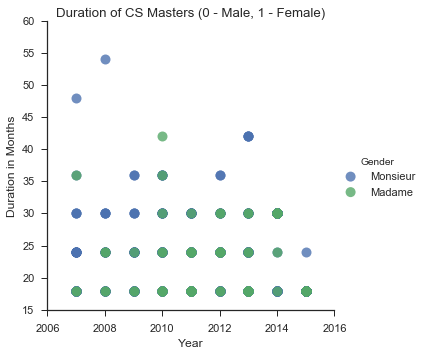

In [61]:
# help from: http://chrisalbon.com/python/seaborn_scatterplot.html
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

sns.lmplot('Start', 'Duration', data=m1_proj, fit_reg=False, hue="Gender", scatter_kws={"marker": "D", "s": 100})
plt.title('Duration of CS Masters (0 - Male, 1 - Female)')
plt.xlabel('Year')
plt.ylabel('Duration in Months')

From the first scatterplot, we can observe that Males usually finish later than Females, particularly those that started in 2007, 2008, 2009, 2012, 2013, and 2015.